In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense,LeakyReLU,Conv2D,Reshape,Conv2DTranspose,Lambda,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(1)

2 Physical GPUs, 2 Logical GPUs


In [88]:
img_path = os.path.join('./archive/img_align_celeba/img_align_celeba')
img_list = os.listdir(img_path)

(218, 178, 3)
(128, 128, 3)


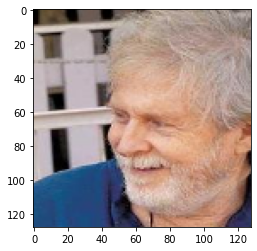

In [89]:
test_img = cv2.imread(img_path + "/" + img_list[0])
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
test_img = np.array(test_img)
print(test_img.shape)
test_img = cv2.resize(test_img,(128,128),interpolation = cv2.INTER_CUBIC)
print(test_img.shape)
plt.imshow(test_img)

In [90]:
print(len(img_list))

202599


In [91]:
data = []
np.random.seed(42)
for i in range(10000):
    number = np.random.randint(0,len(img_list))
    data_img = cv2.imread(img_path + "/" + img_list[number])
    data_img = cv2.cvtColor(data_img,cv2.COLOR_BGR2RGB)
    data_img = np.array(data_img)
    data_img = cv2.resize(data_img,(128,128),interpolation = cv2.INTER_CUBIC)
    data.append(data_img)

data = np.array(data)
data.shape

(10000, 128, 128, 3)

In [92]:
train_data = data[:9000].astype('float32')
test_data = data[9000:].astype('float32')

In [93]:
print(train_data.shape)
print(test_data.shape)

(9000, 128, 128, 3)
(1000, 128, 128, 3)


In [94]:
data_max_pixel = np.max(data)
data_min_pixel = np.min(data)
print(data_max_pixel,data_min_pixel)

train_data = (train_data - data_min_pixel) / (data_max_pixel - data_min_pixel)
test_data = (test_data - data_min_pixel) / (data_max_pixel - data_min_pixel)

print(np.max(train_data),np.min(train_data),np.max(test_data),np.min(test_data))

255 0
1.0 0.0 1.0 0.0


In [95]:
def VAEencoder(input_shape=(128,128,3)):
    encoder_input = Input(shape=input_shape)
    encoder_conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=2,padding='same')(encoder_input)
    batch_normal1 = BatchNormalization()(encoder_conv1)
    activation1 = LeakyReLU()(batch_normal1)
    dropout1 = Dropout(0.25)(activation1)
    encoder_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(dropout1)
    batch_normal2 = BatchNormalization()(encoder_conv2)
    activation2 = LeakyReLU()(batch_normal2)
    dropout2 = Dropout(0.25)(activation2)
    encoder_conv3 = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(dropout2)
    batch_normal3 = BatchNormalization()(encoder_conv3)
    activation3 = LeakyReLU()(batch_normal3)
    dropout3 = Dropout(0.25)(activation3)
    encoder_conv4 = Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same')(dropout3)
    batch_normal4 = BatchNormalization()(encoder_conv4)
    activation4 = LeakyReLU()(batch_normal4)
    dropout4 = Dropout(0.25)(activation4)
    before_number = K.int_shape(activation4)[1:]
    flatten = Flatten()(dropout4)
    mu = Dense(200,name='mu')(flatten)
    log_var = Dense(200,name='log_var')(flatten)
    def sampling(args):
        mu,log_var = args
        epsilon = K.random_normal(shape=K.shape(mu),mean=0.,stddev=1.)
        sampling = mu + K.exp(log_var/2) * epsilon
        return sampling
    
    encoder_output = Lambda(sampling)([mu,log_var])
    encoder_model = Model(encoder_input,encoder_output)

    return encoder_model, before_number,mu,log_var

In [96]:
a , before_number,mu,log_var= VAEencoder()
a.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 64, 64, 32)   896         input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 64, 64, 32)   128         conv2d_36[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_68 (LeakyReLU)      (None, 64, 64, 32)   0           batch_normalization_60[0][0]     
___________________________________________________________________________________________

In [97]:
def VAEdecoder(k,input_shape=(200,)):
    encoder_output = Input(shape=input_shape)
    dense_1 = Dense(np.prod(k),activation='relu')(encoder_output)
    reshape = Reshape(k)(dense_1)
    decoder_conv2d2 = Conv2DTranspose(64,kernel_size=(3,3),strides=2,padding='same')(reshape)
    batch_normal2 = BatchNormalization()(decoder_conv2d2)
    activation_d2 = LeakyReLU()(batch_normal2)
    dropout2 = Dropout(0.25)(activation_d2)
    #32,32,64
    decoder_conv2d3 = Conv2DTranspose(64,kernel_size=(3,3),strides=2,padding='same')(dropout2)
    batch_normal3 = BatchNormalization()(decoder_conv2d3)
    activation_d3 = LeakyReLU()(batch_normal3)
    dropout3 = Dropout(0.25)(activation_d3)
    #64,64,32
    decoder_conv2d4 = Conv2DTranspose(32,kernel_size=(3,3),strides=2,padding='same')(dropout3)
    batch_normal4 = BatchNormalization()(decoder_conv2d4)
    activation_d4 = LeakyReLU()(batch_normal4)
    dropout4 = Dropout(0.25)(activation_d4)

    decoder_conv2d4 = Conv2DTranspose(3,kernel_size=(3,3),strides=2,padding='same')(dropout4)
    activation_d4 = LeakyReLU()(decoder_conv2d4)

    model = Model(encoder_output,activation_d4)
    return model

In [98]:
b = VAEdecoder(before_number)
b.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_64 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 16, 16, 64)        0  

In [99]:
encoder_input = Input(shape=(128,128,3))
Vaeencoder, k,mu,log_var = VAEencoder()
Vaedecoder = VAEdecoder(k)
x = Vaeencoder(encoder_input)
x = Vaedecoder(x)
model = Model(encoder_input,x)
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_25 (Model)             (None, 200)               1732944   
_________________________________________________________________
model_26 (Model)             (None, 128, 128, 3)       917123    
Total params: 2,650,067
Trainable params: 2,649,299
Non-trainable params: 768
_________________________________________________________________


In [102]:
optimizer = Adam(lr=0.0005)
r_loss_factor = 1000

def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return  r_loss + kl_loss

model.compile(optimizer=optimizer, loss = tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

In [103]:
model.fit(train_data,train_data,batch_size=32,epochs=20,validation_data=(test_data,test_data))

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 6s 717us/sample - loss: 0.0846 - accuracy: 0.4828 - val_loss: 0.0235 - val_accuracy: 0.7199
Epoch 2/20
9000/9000 [==============================] - 5s 555us/sample - loss: 0.0293 - accuracy: 0.6362 - val_loss: 0.0202 - val_accuracy: 0.7058
Epoch 3/20
9000/9000 [==============================] - 5s 573us/sample - loss: 0.0237 - accuracy: 0.6714 - val_loss: 0.0161 - val_accuracy: 0.7335
Epoch 4/20
9000/9000 [==============================] - 5s 569us/sample - loss: 0.0198 - accuracy: 0.7185 - val_loss: 0.0138 - val_accuracy: 0.7680
Epoch 5/20
9000/9000 [==============================] - 5s 569us/sample - loss: 0.0174 - accuracy: 0.7480 - val_loss: 0.0131 - val_accuracy: 0.7729
Epoch 6/20
9000/9000 [==============================] - 5s 555us/sample - loss: 0.0160 - accuracy: 0.7626 - val_loss: 0.0120 - val_accuracy: 0.7892
Epoch 7/20
9000/9000 [==============================] - 5s 555us

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


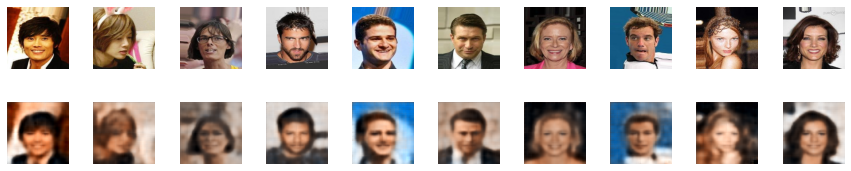

In [104]:
import matplotlib.pyplot as plt
n_to_show = 10
np.random.seed(88)
example_idx = np.random.choice(range(len(test_data)), n_to_show)
example_images = test_data[example_idx]

z_points = Vaeencoder.predict(example_images)

reconst_images = Vaedecoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

20/20 [==============================] - 3s 138ms/step


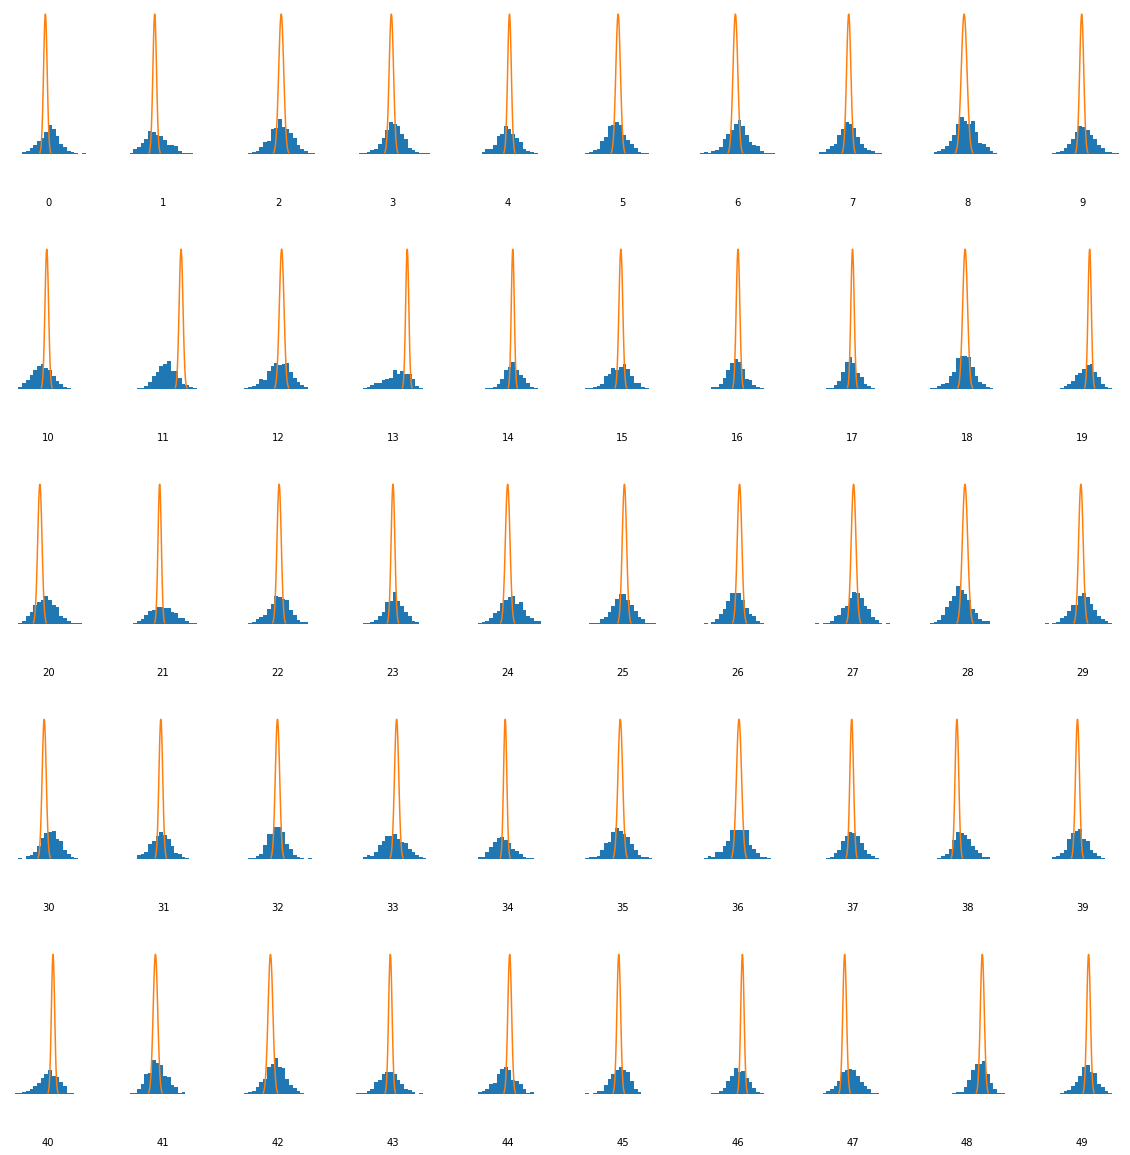

In [107]:
from scipy.stats import norm
z_test = Vaeencoder.predict(test_data, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()